## Packages

In [18]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def load_data(path):
    train_dataset = h5py.File(path+'/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(path+'/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## Dataset

To be familiar with the dataset, load the data by running the cell below.

In [20]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data('dataset/dataset') # you need to change your dataset path

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a non-cat picture.


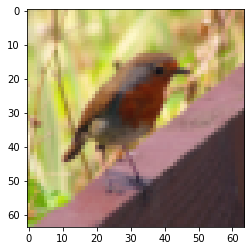

In [21]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [22]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [23]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [24]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [25]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1","W2", "b2":
    """
    np.random.seed(1)
    
    # Initialize parameters randomly
    # I use randn instead of rand, because using randn is more accurate
    # Also, ı also use He initialization technique for weights (source: https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78)
    
    n_x, n_h, n_y = layer_dims
    parameters = {}
    
    parameters["W1"] = np.random.randn(n_h, n_x)*np.sqrt(2/n_x)
    parameters["b1"] = np.random.randn(n_h, 1)*0.01
    parameters["W2"] = np.random.randn(n_y, n_h)*np.sqrt(2/n_h)
    parameters["b2"] = np.random.randn(n_y, 1)*0.01
    
    return parameters

In [26]:
def linear_activation_forward(X, parameters):
    """
    Implement the forward propagation

    Arguments:
    X -- input data:
    parameters -- python dictionary containing your parameters "W1", "b1","W2", "b2":

    Returns:
    AL -- output of the forward propogation
    """
    # Funciton returns values (dictionary) that is includes Z1,A,Z2,AL for easy usage.
    
    # define sigmoid and parameters
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]
    
    # I use "@" oparator for matrix dot multiplacition (source: https://numpy.org/doc/stable/reference/generated/numpy.dot.html)
    
    Z1 = W1@X + b1
    A = np.maximum(Z1, 0) # This is Relu function.
    Z2 = W2@A + b2
    AL = sigmoid(Z2)
    
    values = {
        "Z1": Z1,
        "A" : A,
        "Z2": Z2,
        "AL": AL,
    }
    
    return values

In [27]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cost
    """
    # Cost function formula in single line:
    cost = - (np.sum(Y*np.log(AL) + (1 - Y)*np.log(1 - AL))/ Y.shape[1])
    return cost

In [28]:
def linear_activation_backward(X, Y, values, parameters):
    """
    Implement the backward propagation
    
    Arguments:
    X -- input data
    cost -- cost
    
    Returns:
    grads --  A dictionary with the gradients
             grads["dW1"]
             grads["db1"]
             grads["dW2"]
             grads["db2"]
    """
    # define values.
    Z1 = values["Z1"]
    A = values["A"]
    AL = values["AL"]
    W2 = parameters["W2"]
    
    # My results: 
    # L = - (y*log(AL) + (1-y)*log(1 - AL))
    # dZ_i = dL / dZ_i
    
    # dZ2 = dL/dZ2 = (dL/dAL)*(dAL/dZ2)
    # dL/dAL = (AL - Y)/AL(1 - AL) , dAL/dZ2 = AL*(1 - AL)
    # dZ2 = AL - Y
    dZ2 = AL - Y


    # dZ1 = dL/dZ1 = (dL/dZ2).(dZ2/dA).(dA/dZ1)
    # = (W2(T).dZ2)*derivativeOfRelu(Z1)
    derivativeRelu = np.vectorize(lambda x: 1 if x>0 else 0)
    dZ1 = (W2.transpose()@dZ2)*derivativeRelu(Z1)

    # define grads and set their dimension.

    dw1 = (1/m_train)*(dZ1@X.transpose())
    db1 = (1/m_train)*np.sum(dZ1, axis = 1)
    dw2 = (1/m_train)*(dZ2@A.transpose())
    db2 = (1/m_train)*np.sum(dZ2, axis = 1)
    
    grads = {
        "dW1": dw1,
        "db1": np.expand_dims(db1, axis=1),
        "dW2": dw2,
        "db2": np.expand_dims(db2, axis=1),
    }

    return grads

In [29]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
             parameters["W1"]
             parameters["b1"]
             parameters["W2"]
             parameters["b2"]
    """
    for key in parameters:
      parameters[key] = parameters[key] - learning_rate*grads["d"+key]

    return parameters

In [30]:
def predict(test_x, test_y, parameters):
    """
    Predict test data
    test_x -- test data
    test_y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    
    Returns:
    accuracy -- accuracy of your model
    
    """
    m_example = test_x.shape[1]
    
    # Get AL
    AL = linear_activation_forward(test_x, parameters)["AL"]
    
    # Find Accuracy
    find_results = np.vectorize (lambda x: 1 if x > 0.5 else 0)
    
    # Sum of True statements divided by number of examples. 
    accuracy = np.sum(find_results(AL) == test_y)/m_example*100

    return accuracy

In [31]:
def plot_loss(costs):
    """
    Plot loss
    costs - cost of each iteration  
    """
    
    fig, ax = plt.subplots()
    ax.plot(costs)
    
    # set names
    plt.xlabel(" number of each 100 training ")
    plt.ylabel(" Cost ")
    plt.title(" -- Plot Cost --")
    
    plt.show()

In [32]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### 
        values = linear_activation_forward(X, parameters)
        AL, A, Z1, Z2 = values["AL"], values["A"], values["Z1"], values["Z2"]
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### 
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
        
        
        # Backward propagation.
        ### START CODE HERE ### 
        grads = linear_activation_backward(X, Y, values, parameters)
        ### END CODE HERE ###

        
        # Update parameters.
        ### START CODE HERE ### 
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
        
        # Print the cost every 100 training example
        if i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)

    return parameters, costs

In [33]:
def main():
    parameters, costs = two_layer_model(train_x, train_y, layers_dims, learning_rate = 0.0075, num_iterations = 3000)
    plot_loss(costs)
    accuracy = predict(test_x, test_y, parameters)
    print(f"accuracy of model: % {accuracy} ")
    

Cost after iteration 0: 0.8442035774228018
Cost after iteration 100: 0.6091036473744577
Cost after iteration 200: 0.549442706999768
Cost after iteration 300: 0.4862534443906579
Cost after iteration 400: 0.42007825371062574
Cost after iteration 500: 0.4020006972477563
Cost after iteration 600: 0.36346786483531607
Cost after iteration 700: 0.3107673089450135
Cost after iteration 800: 0.27606288504653875
Cost after iteration 900: 0.23469793564075594
Cost after iteration 1000: 0.2123127860429178
Cost after iteration 1100: 0.1735655858229432
Cost after iteration 1200: 0.1340795654742738
Cost after iteration 1300: 0.12116204788543437
Cost after iteration 1400: 0.08252347705966646
Cost after iteration 1500: 0.06883201224227295
Cost after iteration 1600: 0.05883066806994632
Cost after iteration 1700: 0.05119638052003186
Cost after iteration 1800: 0.04498334197265504
Cost after iteration 1900: 0.04029178074368294
Cost after iteration 2000: 0.03620111057653551
Cost after iteration 2100: 0.032912

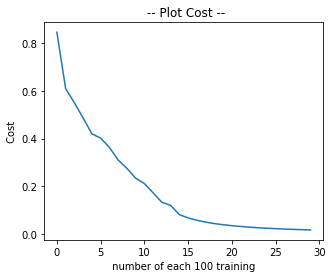

accuracy of model: % 72.0 


In [34]:
main()